In [7]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

In [2]:
n_ch = 20
n = 400

In [3]:
#initialize
TS = np.zeros((n_ch, n))

In [20]:
def create_shape(length, 
                 signal_type = 'gaussian'):
    """
    """
    if signal_type == 'gaussian':
        X = signal.gaussian(length, std=length/7)
        
    return X

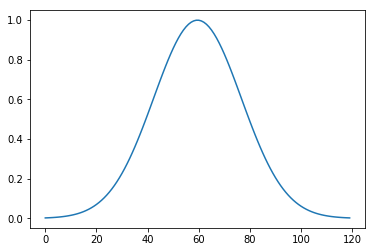

In [11]:
X = create_shape(120)
plt.plot(X)

(400,)


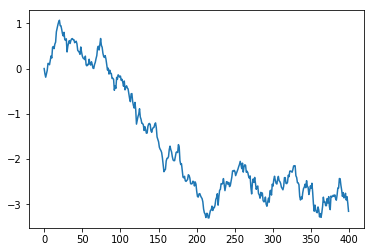

In [53]:
noise_amp = 0.1
n = 400
noise = noise_amp * np.random.normal(0,1,n)
noise = np.array([np.sum(noise[:i]) for i in range(0,noise.shape[0])])
plt.plot(noise)
print(noise.shape)

In [80]:
np.random.normal(0,1,(4,5)).shape

(4, 5)

In [91]:
def create_noise(X,
                 noise_amp = 0.05,
                 noise_type = 'gaussian'):
    """
    """
    n = X.shape[1]
    n_ch = X.shape[0]
        
    if noise_type == 'gaussian':
        noise = noise_amp * np.random.normal(0,1,(n_ch,n))
        return X + noise
    
    elif noise_type == 'random_walk':
        noise = noise_amp * np.random.normal(0,1,(n_ch,n))
        noise = np.array([np.sum(noise[:,:i], axis=1) for i in range(0,noise.shape[1])]).T
        return X + noise        

def generate_channel(n,
                     length,
                     signal_pos,
                     signal_type = 'gaussian',
                     noise_type = 'gaussian',
                     noise_amp = 0.05):
    """
    """
    X = np.zeros((1, n))
    X[0, signal_pos: (signal_pos + length)] = create_shape(length, signal_type = signal_type)
    
    X = create_noise(X, noise_amp = noise_amp, noise_type = noise_type)
        
    return X

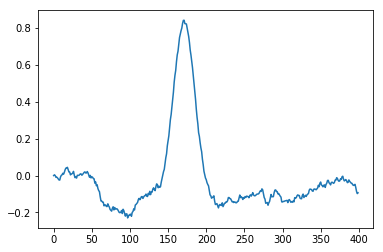

In [93]:
X = generate_channel(n, 100, np.random.randint(0,300), noise_amp = 0.01, noise_type = 'random_walk')
plt.plot(X[0,:])

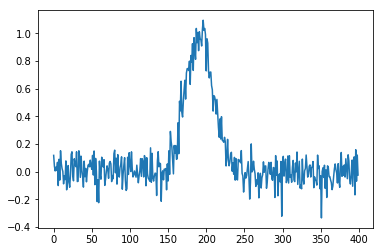

In [37]:
X = generate_channel(n, 120, np.random.randint(0,200), noise_amp = 0.09)
plt.plot(X[0,:])